# Individual Assignment 1 - Titanic Data Preparation and Logistic Regression

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib to display plots inline
%matplotlib inline
sns.set_style("whitegrid")

# load the data
df = pd.read_excel("titanic3.xls")

print(df.head())
print(df.info())
print(df.describe())

   pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St 

## Initial Data Exploration


Unique values in 'embarked': ['S' 'C' nan 'Q']
Unique values in 'sex': ['female' 'male']


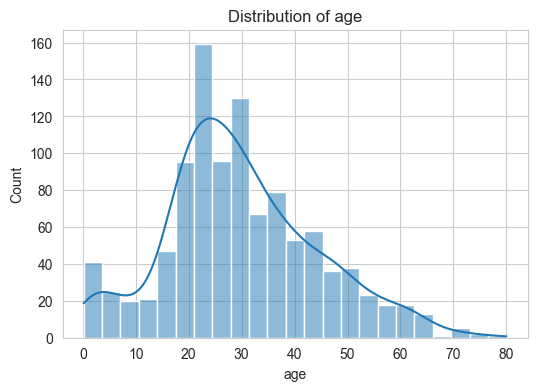

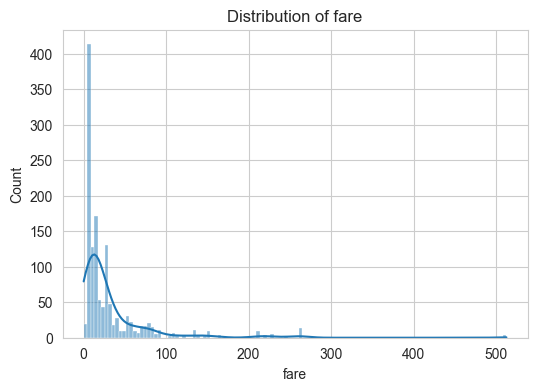

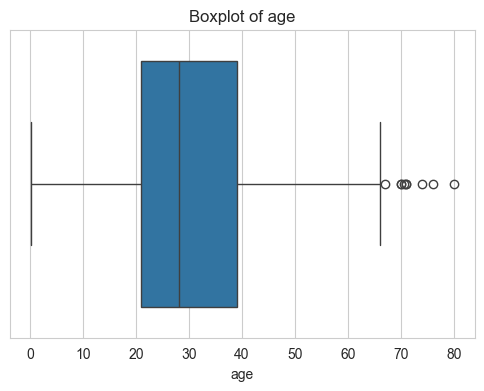

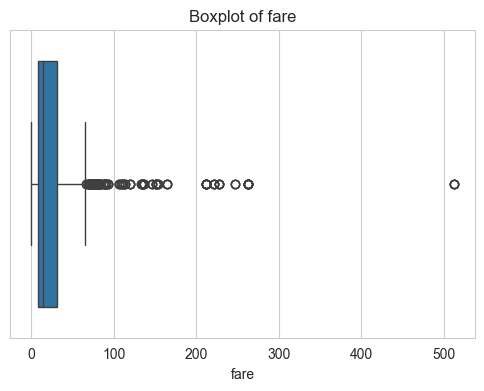

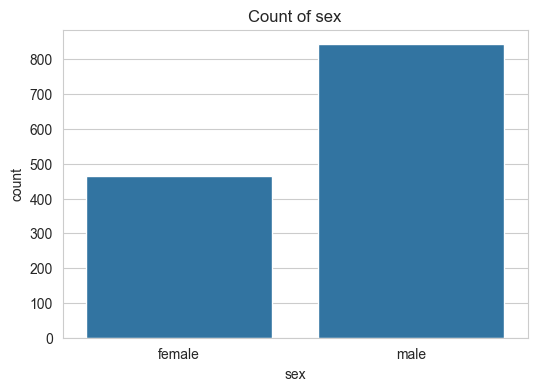

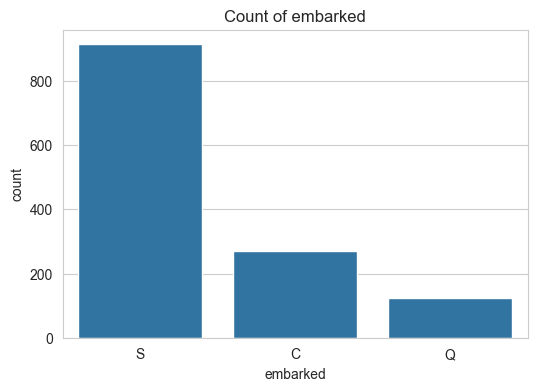

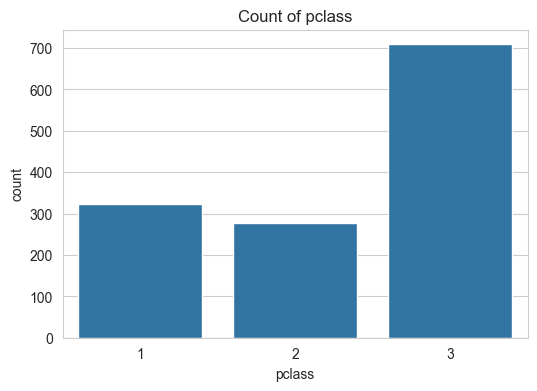

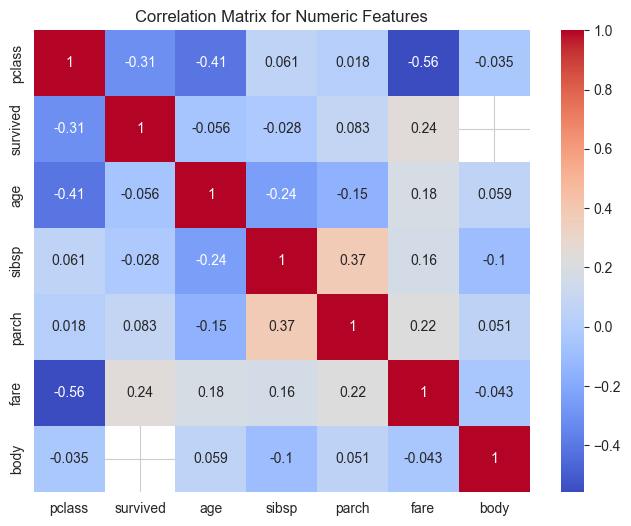

In [4]:
# Check unique values in categorical features
print("Unique values in 'embarked':", df['embarked'].unique())
print("Unique values in 'sex':", df['sex'].unique())

# Visualizations for numerical features: histograms and boxplots
numeric_cols = ['age', 'fare']
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot of {col}")
    plt.show()

# Visualizations for categorical features: count plots
categorical_cols = ['sex', 'embarked', 'pclass']
for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count of {col}")
    plt.show()

# Plot correlation matrix for numeric features
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Numeric Features")
plt.show()

## Missing Data Handling

Our exploration shows missing values in columns like `age` (263 missing), `fare` (1 missing), and `cabin` (very sparse). 
- Impute numerical columns (`age` and `fare`) with the median.
- Impute the categorical column `embarked` with the mode.
- Create a new binary feature `has_cabin` indicating whether a cabin is recorded.
- Drop sparse columns (`cabin`, `boat`, `body`, and `home.dest`) to reduce noise.


In [5]:
# Impute missing numerical values using the median (robust to outliers)
df['age'] = df['age'].fillna(df['age'].median())
df['fare'] = df['fare'].fillna(df['fare'].median())

# Impute missing categorical values for 'embarked' using the mode
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

# Create a new binary feature 'has_cabin': 1 if cabin exists, 0 otherwise
df['has_cabin'] = df['cabin'].notnull().astype(int)

# Drop columns with too many missing values
df.drop('cabin', axis=1, inplace=True)
df.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)

# Verify missing values have been handled
print(df.isnull().sum())


pclass       0
survived     0
name         0
sex          0
age          0
sibsp        0
parch        0
ticket       0
fare         0
embarked     0
has_cabin    0
dtype: int64


## One-Hot Encoding

We convert categorical features (`sex`, `embarked`, and `pclass`) into numerical dummy variables using OneHotEncoder. We use the `drop='first'` option to prevent multicollinearity. then, we drop non-informative columns such as `name` and `ticket`.


In [6]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder with drop='first' to avoid dummy variable trap
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Select categorical columns for encoding
categorical_data = df[['sex', 'embarked', 'pclass']]
encoded_array = encoder.fit_transform(categorical_data)

# Create a DataFrame with the encoded features
encoded_cols = encoder.get_feature_names_out(['sex', 'embarked', 'pclass'])
df_encoded_cols = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

# Merge encoded columns with the rest of the DataFrame and drop original categorical columns
df_encoded = pd.concat([df.drop(['sex', 'embarked', 'pclass'], axis=1), df_encoded_cols], axis=1)

# Drop non-informative columns such as 'name' and 'ticket'
df_model = df_encoded.drop(['name', 'ticket'], axis=1)

# Check resulting DataFrame info
print(df_model.info())
print(df_model.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    1309 non-null   int64  
 1   age         1309 non-null   float64
 2   sibsp       1309 non-null   int64  
 3   parch       1309 non-null   int64  
 4   fare        1309 non-null   float64
 5   has_cabin   1309 non-null   int64  
 6   sex_male    1309 non-null   float64
 7   embarked_Q  1309 non-null   float64
 8   embarked_S  1309 non-null   float64
 9   pclass_2    1309 non-null   float64
 10  pclass_3    1309 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 112.6 KB
None
   survived      age  sibsp  parch      fare  has_cabin  sex_male  embarked_Q  \
0         1  29.0000      0      0  211.3375          1       0.0         0.0   
1         1   0.9167      1      2  151.5500          1       1.0         0.0   
2         0   2.0000      1      2  151.5500          1     

## Feature Scaling and Normalization

We need to scale our numerical features (`age`, `fare`, `sibsp`, and `parch`) for our Logistic Regression model. First, we standardize the features using StandardScaler, which scales data to have zero mean and unit variance. Additionally, we create a normalized version with MinMaxScaler that rescales features to the [0, 1] range. Standardization is preferred when the data roughly follows a normal distribution, while normalization is useful when features have different units or bounds.


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the numerical columns to scale
numeric_cols = ['age', 'fare', 'sibsp', 'parch']

# Standardization using StandardScaler
scaler = StandardScaler()
df_model[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])

print("Standardized Data (first 5 rows):")
print(df_model.head())

# Create a separate copy for normalization using MinMaxScaler
df_model_norm = df_model.copy()
minmax_scaler = MinMaxScaler()
df_model_norm[numeric_cols] = minmax_scaler.fit_transform(df_model_norm[numeric_cols])

print("Normalized Data (first 5 rows):")
print(df_model_norm.head())


Standardized Data (first 5 rows):
   survived       age     sibsp     parch      fare  has_cabin  sex_male  \
0         1 -0.039005 -0.479087 -0.445000  3.442584          1       0.0   
1         1 -2.215952  0.481288  1.866526  2.286639          1       1.0   
2         0 -2.131977  0.481288  1.866526  2.286639          1       0.0   
3         0  0.038512  0.481288  1.866526  2.286639          1       1.0   
4         0 -0.349075  0.481288  1.866526  2.286639          1       0.0   

   embarked_Q  embarked_S  pclass_2  pclass_3  
0         0.0         1.0       0.0       0.0  
1         0.0         1.0       0.0       0.0  
2         0.0         1.0       0.0       0.0  
3         0.0         1.0       0.0       0.0  
4         0.0         1.0       0.0       0.0  
Normalized Data (first 5 rows):
   survived       age  sibsp     parch      fare  has_cabin  sex_male  \
0         1  0.361169  0.000  0.000000  0.412503          1       0.0   
1         1  0.009395  0.125  0.222222  0.2

## Data Splitting

Next, we separate our target variable (`survived`) from the features and split the data into training (60%), validation (20%), and test sets (20%). We use stratified sampling to ensure that the target variable’s distribution is consistent across all sets.


In [8]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_model.drop('survived', axis=1)
y = df_model['survived']

# First split: 60% training, 40% temporary
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Second split: Divide temporary set equally into validation and test sets (each 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Target distribution in training set:")
print(y_train.value_counts())


Training set shape: (785, 10)
Validation set shape: (262, 10)
Test set shape: (262, 10)
Target distribution in training set:
survived
0    485
1    300
Name: count, dtype: int64


## Feature Selection

To reduce redundancy and overfitting, we now perform feature selection on the training data. We first use a VarianceThreshold to remove features with no variance. Then, we examine the correlation matrix to drop any highly correlated features (correlation greater than 0.8). This step is done post-splitting to avoid data leakage from the validation and test sets.


In [9]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with zero variance 
variance_selector = VarianceThreshold(threshold=0.0)
X_train_var = variance_selector.fit_transform(X_train)

# Get the names of the features that passed the variance threshold
selected_features = X_train.columns[variance_selector.get_support()]
print("Features remaining after low variance filtering:", list(selected_features))

# Convert training data to DataFrame for correlation analysis
X_train_df = pd.DataFrame(X_train[selected_features], columns=selected_features)

# Compute the absolute correlation matrix
corr_matrix = X_train_df.corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify features with a correlation greater than 0.8 to drop
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Highly correlated features to drop:", to_drop)

# Final selected features (drop the highly correlated ones)
final_features = [feat for feat in selected_features if feat not in to_drop]
print("Final features selected:", final_features)

# Apply the feature selection to training, validation, and test sets
X_train_sel = X_train[final_features]
X_val_sel = X_val[final_features]
X_test_sel = X_test[final_features]


Features remaining after low variance filtering: ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass_2', 'pclass_3']
Highly correlated features to drop: []
Final features selected: ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'sex_male', 'embarked_Q', 'embarked_S', 'pclass_2', 'pclass_3']


## Balancing the Training Data with SMOTE

Since our target variable `survived` is imbalanced (more 0's than 1's), we use SMOTE to generate synthetic samples for the minority class in the training set. This helps our model learn more balanced decision boundaries.


In [18]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE and apply it only on the training data
# TODO: FIND OUT WHY THROWING AN ERROR: Expression with type "tuple[Unknown | DataFrame | ... | Series[Unknown], Unknown | DataFrame | ... | Series[Unknown]] | tuple[Unknown | DataFrame | ... | Series[Unknown], Unknown | DataFrame | ... | Series[Unknown], Unknown]" cannot be assigned to target tuple
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sel, y_train)

print("After SMOTE, target distribution in training set:")
print(y_train_res.value_counts())


After SMOTE, target distribution in training set:
survived
0    485
1    485
Name: count, dtype: int64


## Model Training – Initial Logistic Regression

We now train a Logistic Regression model using the SMOTE-resampled training data. After training, we evaluate the model on the validation set using accuracy, the confusion matrix, and a classification report. We also plot the ROC curve to better understand the model’s performance.


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_res, y_train_res)

# Predict on the validation set
y_val_pred = model.predict(X_val_sel)

# Evaluate model performance on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7824427480916031
Confusion Matrix:
 [[135  27]
 [ 30  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       162
           1       0.72      0.70      0.71       100

    accuracy                           0.78       262
   macro avg       0.77      0.77      0.77       262
weighted avg       0.78      0.78      0.78       262



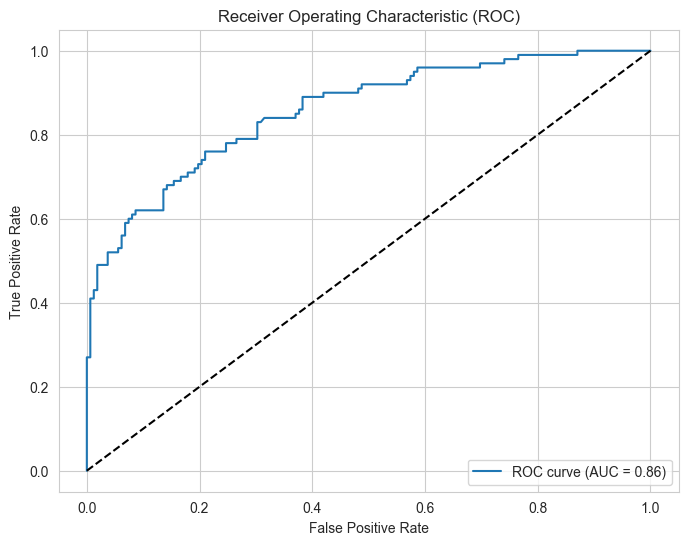

In [12]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_val_proba = model.predict_proba(X_val_sel)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Reference line for a random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


## Hyperparameter Tuning with GridSearchCV

We now tune our Logistic Regression model using GridSearchCV. This step uses 5-fold stratified cross-validation on the SMOTE-resampled training data to find the best parameters. In our grid, we try different values of the regularization strength `C` and both L1 and L2 penalties using the `liblinear` solver.


In [13]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # liblinear supports both l1 and l2
}

# Set up stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# init GridSearchCV with Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Retrieve the best estimator
best_model = grid_search.best_estimator_

# Evaluate on the validation set
val_preds = best_model.predict(X_val_sel)
print("Validation Accuracy (Best Model):", accuracy_score(y_val, val_preds))


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Score: 0.7742268041237114
Validation Accuracy (Best Model): 0.7786259541984732


## Final Evaluation on the Test Set

Finally, we evaluate our best model on the test set to see how it performs on unseen data.


In [14]:
# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test_sel)

# Evaluate the performance on the test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.8129770992366412
Test Confusion Matrix:
 [[131  31]
 [ 18  82]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       162
           1       0.73      0.82      0.77       100

    accuracy                           0.81       262
   macro avg       0.80      0.81      0.81       262
weighted avg       0.82      0.81      0.81       262



## Final Summary and Conclusions

1. **Exploratory Data Analysis:** We examined the data structure, missing values, and distributions.
2. **Missing Value Handling:** We imputed numerical columns with the median, filled categorical missing values, and created a binary indicator for cabin information.
3. **One-Hot Encoding:** Categorical features were transformed into dummy variables.
4. **Feature Scaling:** We standardized numerical features using StandardScaler and also created a normalized version using MinMaxScaler. Standardization helps when data is roughly normal, while normalization is useful for ensuring a fixed range.
5. **Data Splitting:** The dataset was split into training (60%), validation (20%), and test (20%) sets using stratification.
6. **Feature Selection:** To avoid overfitting, we removed low variance features and dropped highly correlated features (if any) using only the training data.
7. **Class Balancing:** SMOTE was applied on the training set to balance the class distribution.
8. **Model Training & Tuning:** We trained a Logistic Regression model, tuned its hyperparameters with GridSearchCV, and evaluated its performance using accuracy, confusion matrices, classification reports, and ROC curves.

Our final tuned Logistic Regression model achieved approximately **81.3% accuracy** on the test set. 
